# Radius of Non-Singularity
This code is used for calculating the radius of Non-Singularity with Quantum Logic. It follows along the Paper "Verifying Interval Matrix properties on a quantum computer" [Jan Schneider, Julian Berberich 2023].

The considered problem is given as $ d(A,\Delta)=\frac{1}{\max\{\rho_0(A^{-1}T_y \Delta T_z)|y,z \in Q_n \}} $. We can see here that the important part is the denominator, where we have to solve a binary optimization problem. For problem formulations like this, the Quantum Approximate Optimization Algorithm is very useful and hence is used in this code. 

Initially, we give the code a problem specific $ A^{-1} $ and a $ \delta $ matrix. We restrained conditions on $\Delta$ being a rank $1$ Matrix. This code works for $\Delta=\delta^Te$. Since the inversion of a Matrix can be done in polynomial time, it does not infect the complexity and we directly give the code an inverse. This is also due to numerical reasons. The code then calculates $ \max\{\rho_0(A^{-1}T_y \Delta T_z)|y,z \in Q_n \} $ and gives back the solution string with the highest amount of counts. In other words, that solution which resulted during the optimization the highest ammount of times as the optimum. This script uses an open source toolbox called "Pennylane" [V. Bergholm, J. Izaac, M. Schuld, et al., “Pennylane: Automatic differentiation of hybrid quantum-classical computations,” arXiv:1811.04968, 2018.] allowing to implement quantum logic and algorithms in an appropriate framework. The code is based on a [pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut/) for implementing the maxcut problem, which is closely related to the discussed problem. 

We start by importing all the necessary libraries.

In [37]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
#np.random.seed(42)

In the next cell we set up our initial Problem. Since the Instance to the algorithm is a Matrix, we somehow have to incorporate this to the algorithm. A very convenient approach of working with matrices is by transforming them into bipartite graphs. The idea behind this relies on the correlation between the maxcut quantum algorithm and our problem set up. These Graphs exist of 2 distinct subsets representing our $n\times n$ space. Hence we need $n$ vertices per subset in order to represent a $n\times n$ Matrix. Note that it would not be necessary to do this step, it is just easier to incorporate the right edges at the right places. 

The bipartite graph representation of a matrix is then fairly simple. The $ i,j $-th matrix entry is represented by connecting node $ i $ of the first subset with node $ j$ of the second one with a weighted edge. The edge weight represents the value of the matrix entry.

What we end up with is a function to convert matrices in a bipartite graph and the setup of $ A $ and $ \delta $.

In [38]:
def convert_to_bipartite(A):
    bip = nx.Graph()
    n = np.sqrt(A.size).astype(int)
    nodes_1 = list(range(0,n))
    nodes_2 = list(range(n,2*n))
    bip.add_nodes_from(nodes_1,bipartite=0)
    bip.add_nodes_from(nodes_2,bipartite=1)
    for i in range(n):
        for j in range(n,2*n):
            bip.add_edge(i,j,weight = A[i,j-n])
    
    pos = nx.bipartite_layout(bip,nodes_1)
    return bip,pos

#define Graph
#A_m2 = np.array([[1,0,1,1],[1,1,0,1],[0,1,1,1],[1,1,1,0]])
A_m2 = np.array([[-0.7333,-0.2333,0.1],[-0.2333,-0.2333,0.1],[0.1,0.1,0.1]])
G,pos = convert_to_bipartite(A_m2)
dimension = np.sqrt(A_m2.size).astype(int) #matrix dimension

edges = list(G.edges())
weighted_edges = nx.get_edge_attributes(G, 'weight')
#print(weighted_edges)#printing the edges and the according weights (matrix entrys)

#define uncertainty
#Delta = np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]])
Delta = np.array([[1,1,1],[1,1,1],[1,1,1]])
G_D,pos_D = convert_to_bipartite(Delta)

edges_D = list(G_D.edges())
weighted_edges_D = nx.get_edge_attributes(G_D, 'weight')
#print(weighted_edges_D)

Next, we have to initialize the necessary things for the QAOA algorithm. QAOAs working principle is applying a problem unitary $ U(\gamma) $ and a mixing unitary $ U(\beta) $ alternating a certain ammount of times on an initial quantum state in super position. Then, the expactation value is evaluated and both variables $ \gamma $ and $ \beta $ are optimized. After a sufficient amount of optimization iterations, the expectation value of the quantum circuit is evaluated with the optimal parameters $100$ times. Now, the optimal solution strings are more likely to be the results of the expectation values. Hence, every binary string from the expectation value gets a count at each iteration. This way, an histogram over all possible solution strings can be determined, indicating an optimal solution, which precision heavily relies on the optimization iterations and the problem complexity.

The core of the quantum algorithm are the problem and mixing Unitary $U(\gamma)$ and $U(\beta)$. Hence, the first thing we do is to initialize the necessary number of qubits and define appropriate Unitaries according to Eq.~(25) and Theorem~(5). As stated in the paper, double the amount of qubits then system dimensions are required, i.e. $n_{qubits}=2*n$. Besides, note that in the given problem Hamiltonian, the $i$-th and the $(n+j)$-th qubit are entangled using the $Z$-gates. However, it is sufficient for the definition to iterate over all edges of the graph. Due to its bipartite structure, this exact relation can be represented easily.

In [39]:
n_wires = 2*dimension

# unitary operator U_B with parameter beta as mixing hamiltonian
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma as cost hamiltonian
def U_C(gamma):
    for edge in edges:
        wire1 = edge[0]
        wire2 = edge[1]
        weight_A = weighted_edges[edge]
        weight_Delta = weighted_edges_D[edge] #new imposed weight from uncertainty description
        weight = weight_A*weight_Delta
        #addd appropriate weight with weight = weight_A*weight_Delta and adressed wires according to Theorem 5
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma*weight, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

We require a method to translate a bitstring, which signifies a sample of several qubits in the computational basis, into an integer or decimal representation.

In [40]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

Next, the algorithm can be constructed. It follows a standard approach, also explained in the paper, by initially transforming the qubits into superposition. Then the problem and mixing Unitaries are applied in an alternating fashion. The algorithm then either returns an expectation value for the algorithm or an approximate optimal bit string. More details on the code structure can be found in the pennylane tutorial.

In [41]:
dev = qml.device("lightning.qubit", wires=n_wires, shots=1) #create a quantum device
@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample()
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

Finally, the optimization is done by using the AdagradOptimizer and minimizing the negative objective function $-C(x)$, which is also imposed regarding the problem formulation in the paper. The optimization is carried out with one and four layers, differing in computational complexity but also drastically in the precision of the histogram. Finding an appropriate compromise between these two characteristics by adapting layers and optimization iterations is crucial for a satisfactory performance.

In [42]:
def qaoa_rns(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in edges:
            # objective for the MaxCut problem
            weight_A = weighted_edges[edge]
            weight_Delta = weighted_edges_D[edge] #new imposed weight from uncertainty description
            weight = weight_A*weight_Delta
            neg_obj -= weight*circuit(gammas, betas, edge=edge, n_layers=n_layers)
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 100
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:08b}".format(most_freq_bit_string))

    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_rns(n_layers=1)[1]
bitstrings2 = qaoa_rns(n_layers=4)[1]


p=1
Objective after step     5:  1.0000000
Objective after step    10:  0.8000000
Objective after step    15:  0.8000000
Objective after step    20:  1.0666000
Objective after step    25:  1.3332000
Objective after step    30:  1.0666000
Objective after step    35:  1.0666000
Objective after step    40:  1.2666000
Objective after step    45:  1.5332000
Objective after step    50:  1.5332000
Objective after step    55:  1.1332000
Objective after step    60:  1.3332000
Objective after step    65:  1.5332000
Objective after step    70:  1.0666000
Objective after step    75:  1.0666000
Objective after step    80:  0.6666000
Objective after step    85:  1.5332000
Objective after step    90:  1.0666000
Objective after step    95:  1.5332000
Objective after step   100:  1.3332000
Optimized (gamma, beta) vectors:
[[1.82286653]
 [0.29387898]]
Most frequently sampled bit string is: 00001110

p=4
Objective after step     5: -0.2666000
Objective after step    10:  1.0666000
Objective after step  

At the end, the results are plotted.

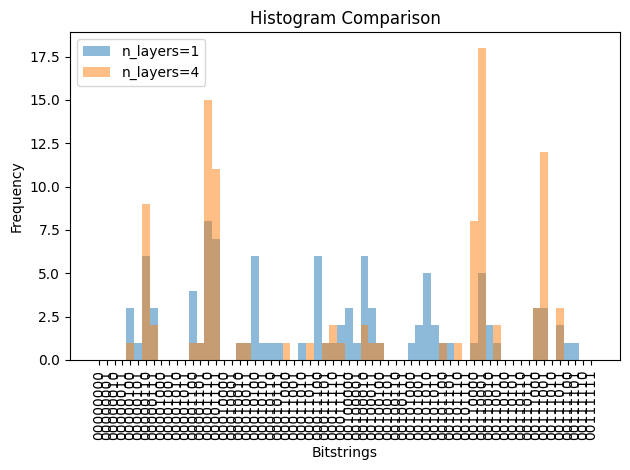

In [45]:
import matplotlib.pyplot as plt

xticks = range(0, 2**n_wires)
xtick_labels = list(map(lambda x: format(x, "08b"), xticks))
bins = np.arange(0, 2**n_wires + 1) - 0.5

plt.title("Histogram Comparison")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")

plt.hist(bitstrings1, bins=bins, alpha=0.5, label="n_layers=1")  # Plot first histogram
plt.hist(bitstrings2, bins=bins, alpha=0.5, label="n_layers=4")  # Plot second histogram

plt.legend()  # Display legend

plt.tight_layout()
plt.show()

In [47]:
import numpy as np
import collections

# Your array
numbers = bitstrings2

# Count the occurrences of each number
number_counts = collections.Counter(numbers)

# Get the top 5 most common numbers
top_5_numbers = number_counts.most_common(5)

# Print the result
print("Top 5 most common numbers:")
for number, count in top_5_numbers:
    print(f"Number: {number+1}, Count: {count}")

Top 5 most common numbers:
Number: 50, Count: 18
Number: 15, Count: 15
Number: 58, Count: 12
Number: 16, Count: 11
Number: 7, Count: 9
